# Example of the solution the regression problem
# Laptop price prediction
[source of the data + code of example](https://www.kaggle.com/datasets/anubhavgoyal10/laptop-prices-dataset/data)

## 0. Import the dependencies

In [1]:
import os

import numpy as np # linear algebra
import pandas as pd 

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn import tree

from sklearn.model_selection import GridSearchCV

## 1. Load the data

In [3]:
df = pd.read_csv("./src/laptop_price.csv")
df.head()

,brand,processor_brand,processor_name,processor_gnrtn,ram_gb,ram_type,ssd,hdd,os,os_bit,graphic_card_gb,weight,warranty,Touchscreen,msoffice,Price,rating,Number of Ratings,Number of Reviews
0,ASUS,Intel,Core i3,10th,4 GB,DDR4,0 GB,1024 GB,Windows,64-bit,0 GB,Casual,No warranty,No,No,34649,2 stars,3,0
1,Lenovo,Intel,Core i3,10th,4 GB,DDR4,0 GB,1024 GB,Windows,64-bit,0 GB,Casual,No warranty,No,No,38999,3 stars,65,5
2,Lenovo,Intel,Core i3,10th,4 GB,DDR4,0 GB,1024 GB,Windows,64-bit,0 GB,Casual,No warranty,No,No,39999,3 stars,8,1
3,ASUS,Intel,Core i5,10th,8 GB,DDR4,512 GB,0 GB,Windows,32-bit,2 GB,Casual,No warranty,No,No,69990,3 stars,0,0
4,ASUS,Intel,Celeron Dual,Not Available,4 GB,DDR4,0 GB,512 GB,Windows,64-bit,0 GB,Casual,No warranty,No,No,26990,3 stars,0,0


## 2. Preprocess the data

In [4]:
df.columns

Index(['brand', 'processor_brand', 'processor_name', 'processor_gnrtn',
       'ram_gb', 'ram_type', 'ssd', 'hdd', 'os', 'os_bit', 'graphic_card_gb',
       'weight', 'warranty', 'Touchscreen', 'msoffice', 'Price', 'rating',
       'Number of Ratings', 'Number of Reviews'],
      dtype='object')

In [5]:
# select few feature to predict the price of laptop
selected_columns = ['brand', 'processor_brand', 'processor_name', 'processor_gnrtn',
                    'ram_gb', 'ram_type', 'ssd', 'hdd', 'os', 'os_bit', 'graphic_card_gb',
                    'weight', 'warranty', 'Touchscreen', 'Price']
df_train = df[selected_columns]

In [6]:
# check Null values in data column
print(df_train.isnull().sum())

brand              0
processor_brand    0
processor_name     0
processor_gnrtn    0
ram_gb             0
ram_type           0
ssd                0
hdd                0
os                 0
os_bit             0
graphic_card_gb    0
weight             0
warranty           0
Touchscreen        0
Price              0
dtype: int64


In [7]:
# checking for duplicated rows
df_train.duplicated().sum()

np.int64(41)

In [8]:
# check overview of columns, their data types, and non-null counts.
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 823 entries, 0 to 822
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   brand            823 non-null    object
 1   processor_brand  823 non-null    object
 2   processor_name   823 non-null    object
 3   processor_gnrtn  823 non-null    object
 4   ram_gb           823 non-null    object
 5   ram_type         823 non-null    object
 6   ssd              823 non-null    object
 7   hdd              823 non-null    object
 8   os               823 non-null    object
 9   os_bit           823 non-null    object
 10  graphic_card_gb  823 non-null    object
 11  weight           823 non-null    object
 12  warranty         823 non-null    object
 13  Touchscreen      823 non-null    object
 14  Price            823 non-null    int64 
dtypes: int64(1), object(14)
memory usage: 96.6+ KB


In [9]:
# make to different variables for categorical and numerical feature identification
cat_val = df_train.select_dtypes(include=['object']).columns
num_val = df_train.select_dtypes(include=['int', "float"]).columns

print(cat_val,'\n',num_val)

Index(['brand', 'processor_brand', 'processor_name', 'processor_gnrtn',
       'ram_gb', 'ram_type', 'ssd', 'hdd', 'os', 'os_bit', 'graphic_card_gb',
       'weight', 'warranty', 'Touchscreen'],
      dtype='object') 
 Index(['Price'], dtype='object')


In [10]:
# check all unique values in features
for column in df_train.columns:
    unique_values = df_train[column].unique()
    print(f"Unique values in column '{column}': {unique_values}")

Unique values in column 'brand': ['ASUS' 'Lenovo' 'acer' 'Avita' 'HP' 'DELL' 'MSI' 'APPLE']
Unique values in column 'processor_brand': ['Intel' 'AMD' 'M1']
Unique values in column 'processor_name': ['Core i3' 'Core i5' 'Celeron Dual' 'Ryzen 5' 'Core i7' 'Core i9' 'M1'
 'Pentium Quad' 'Ryzen 3' 'Ryzen 7' 'Ryzen 9']
Unique values in column 'processor_gnrtn': ['10th' 'Not Available' '11th' '7th' '8th' '9th' '4th' '12th']
Unique values in column 'ram_gb': ['4 GB' '8 GB' '16 GB' '32 GB']
Unique values in column 'ram_type': ['DDR4' 'LPDDR4' 'LPDDR4X' 'DDR5' 'DDR3' 'LPDDR3']
Unique values in column 'ssd': ['0 GB' '512 GB' '256 GB' '128 GB' '1024 GB' '2048 GB' '3072 GB']
Unique values in column 'hdd': ['1024 GB' '0 GB' '512 GB' '2048 GB']
Unique values in column 'os': ['Windows' 'DOS' 'Mac']
Unique values in column 'os_bit': ['64-bit' '32-bit']
Unique values in column 'graphic_card_gb': ['0 GB' '2 GB' '4 GB' '6 GB' '8 GB']
Unique values in column 'weight': ['Casual' 'ThinNlight' 'Gaming']
Uniq

In [11]:
# Removed units ('GB', 'years', 'bit', etc.) from certain columns using string manipulation (str.replace) 
# and transformed them into appropriate numeric types (astype or pd.to_numeric)
df_train['ram_gb'] = df_train['ram_gb'].str.replace('GB','')
df_train['ssd'] = df_train['ssd'].str.replace('GB','')
df_train['hdd'] = df_train['hdd'].str.replace('GB','')
df_train['graphic_card_gb'] = df_train['graphic_card_gb'].str.replace('GB','')
df_train['os_bit'] = df_train['os_bit'].str.replace('-bit','')
df_train['warranty'] = df_train['warranty'].str.replace(r'\byears?\b', '', regex=True)
df_train['processor_gnrtn'] = df_train['processor_gnrtn'].str.replace('th','')


df_train['ram_gb'] = df_train['ram_gb'].astype('int32')
df_train['ssd'] = df_train['ssd'].astype('int32')
df_train['hdd'] = df_train['hdd'].astype('int32')
df_train['graphic_card_gb'] = df_train['graphic_card_gb'].astype('int32')
df_train['os_bit'] = df_train['os_bit'].astype('int32')

df_train.head()

,brand,processor_brand,processor_name,processor_gnrtn,ram_gb,ram_type,ssd,hdd,os,os_bit,graphic_card_gb,weight,warranty,Touchscreen,Price
0,ASUS,Intel,Core i3,10,4,DDR4,0,1024,Windows,64,0,Casual,No warranty,No,34649
1,Lenovo,Intel,Core i3,10,4,DDR4,0,1024,Windows,64,0,Casual,No warranty,No,38999
2,Lenovo,Intel,Core i3,10,4,DDR4,0,1024,Windows,64,0,Casual,No warranty,No,39999
3,ASUS,Intel,Core i5,10,8,DDR4,512,0,Windows,32,2,Casual,No warranty,No,69990
4,ASUS,Intel,Celeron Dual,Not Available,4,DDR4,0,512,Windows,64,0,Casual,No warranty,No,26990


In [12]:
# Convert to numeric, 'Not Available' becomes NaN
df_train['processor_gnrtn'] = pd.to_numeric(df_train['processor_gnrtn'], errors='coerce')  # Convert to numeric, 'Not Available' becomes NaN
median_value = df_train['processor_gnrtn'].median()

In [13]:
df_train['processor_gnrtn'].fillna(median_value, inplace=True)
df_train['processor_gnrtn'] = df_train['processor_gnrtn'].astype(int)

In [14]:
df_train.head()

,brand,processor_brand,processor_name,processor_gnrtn,ram_gb,ram_type,ssd,hdd,os,os_bit,graphic_card_gb,weight,warranty,Touchscreen,Price
0,ASUS,Intel,Core i3,10,4,DDR4,0,1024,Windows,64,0,Casual,No warranty,No,34649
1,Lenovo,Intel,Core i3,10,4,DDR4,0,1024,Windows,64,0,Casual,No warranty,No,38999
2,Lenovo,Intel,Core i3,10,4,DDR4,0,1024,Windows,64,0,Casual,No warranty,No,39999
3,ASUS,Intel,Core i5,10,8,DDR4,512,0,Windows,32,2,Casual,No warranty,No,69990
4,ASUS,Intel,Celeron Dual,11,4,DDR4,0,512,Windows,64,0,Casual,No warranty,No,26990


In [15]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 823 entries, 0 to 822
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   brand            823 non-null    object
 1   processor_brand  823 non-null    object
 2   processor_name   823 non-null    object
 3   processor_gnrtn  823 non-null    int64 
 4   ram_gb           823 non-null    int32 
 5   ram_type         823 non-null    object
 6   ssd              823 non-null    int32 
 7   hdd              823 non-null    int32 
 8   os               823 non-null    object
 9   os_bit           823 non-null    int32 
 10  graphic_card_gb  823 non-null    int32 
 11  weight           823 non-null    object
 12  warranty         823 non-null    object
 13  Touchscreen      823 non-null    object
 14  Price            823 non-null    int64 
dtypes: int32(5), int64(2), object(8)
memory usage: 80.5+ KB


In [16]:
df_train.isnull().sum()

brand              0
processor_brand    0
processor_name     0
processor_gnrtn    0
ram_gb             0
ram_type           0
ssd                0
hdd                0
os                 0
os_bit             0
graphic_card_gb    0
weight             0
warranty           0
Touchscreen        0
Price              0
dtype: int64

## 3. Do data visualization

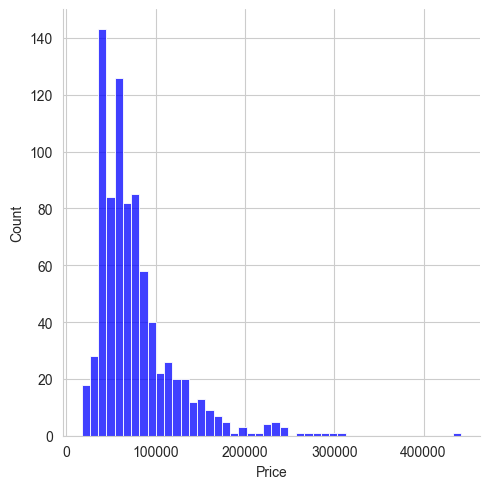

In [17]:
sns.displot(df['Price'],color='blue')

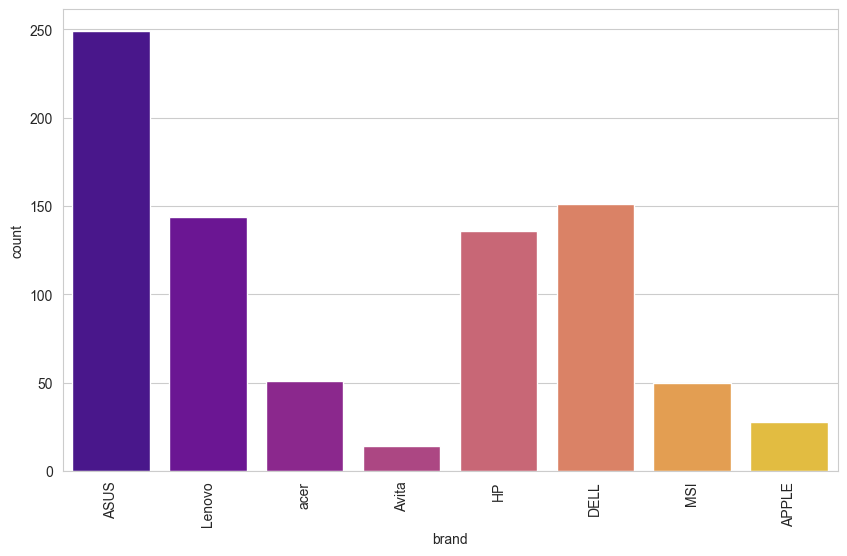

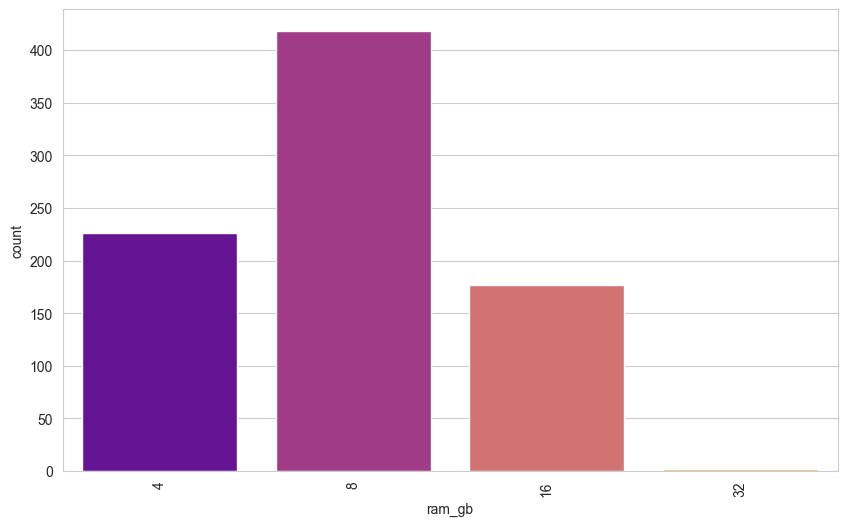

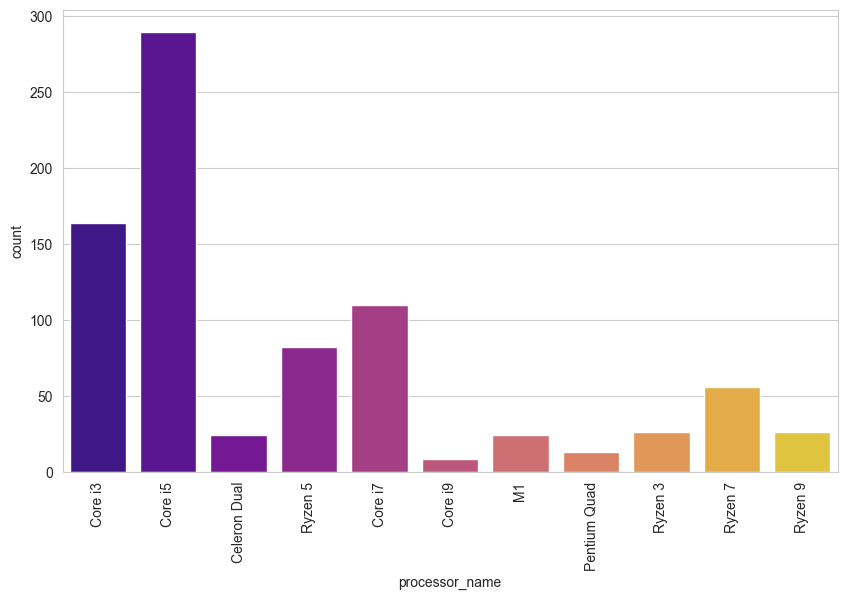

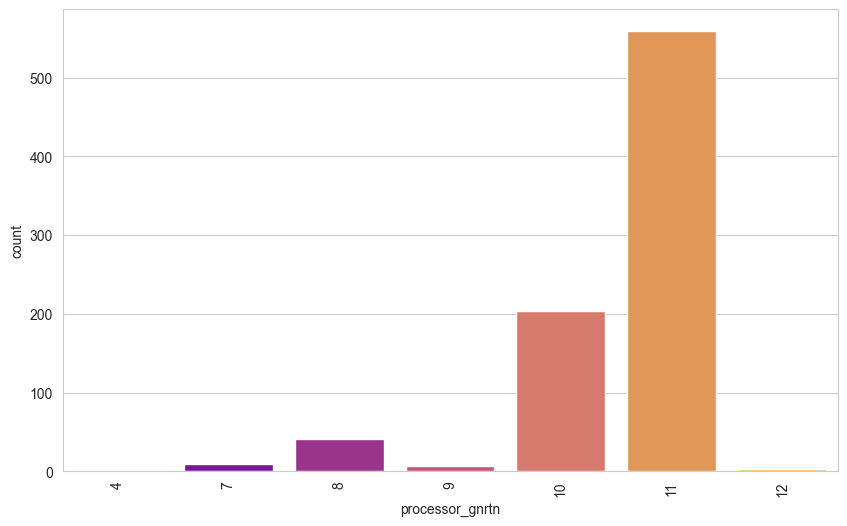

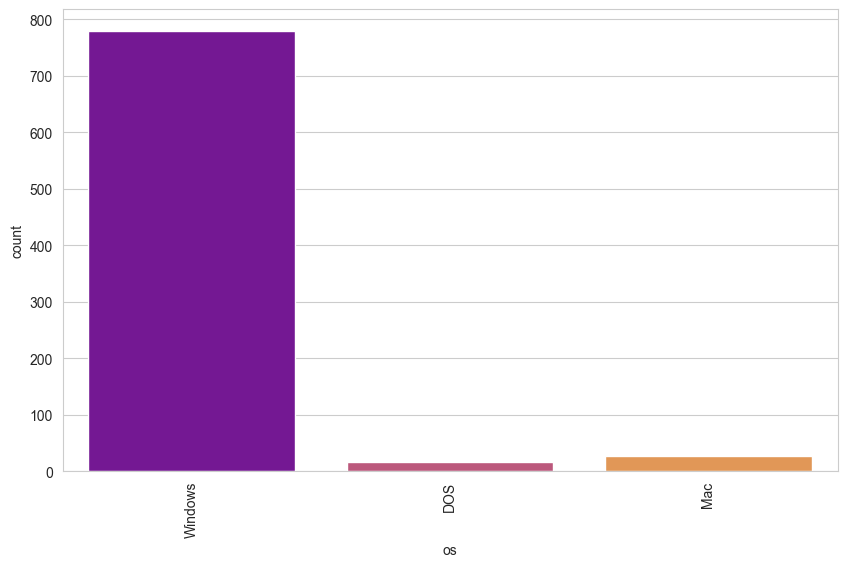

In [18]:
def dataplot(col):
    plt.figure(figsize= (10,6))
    sns.countplot(data = df_train, x=col, palette = 'plasma')
    plt.xticks(rotation = 'vertical')
    plt.show()
    
features = ['brand', 'ram_gb', 'processor_name', 'processor_gnrtn', 'os']

for col in features:
    dataplot(col)

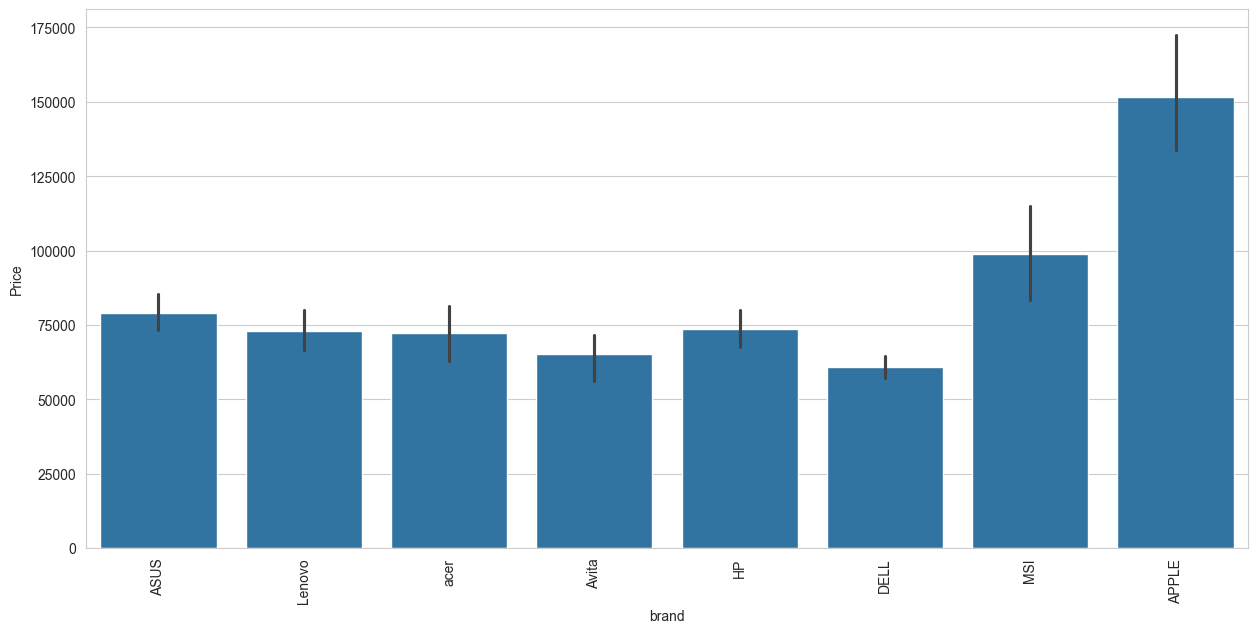

In [19]:
plt.figure(figsize=(15,7))
sns.barplot(x = df_train['brand'], y=df_train['Price'])
plt.xticks(rotation = 'vertical')
plt.show()

### Visualize the Touchscreen feature

<Axes: xlabel='Touchscreen', ylabel='count'>

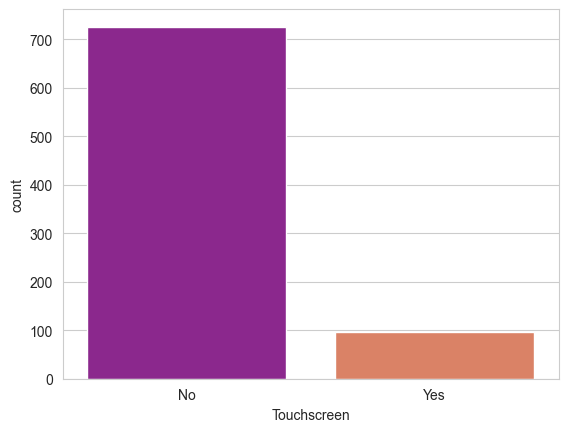

In [20]:
sns.countplot(df_train, x =df_train['Touchscreen'],palette='plasma')

<Axes: xlabel='Touchscreen', ylabel='Price'>

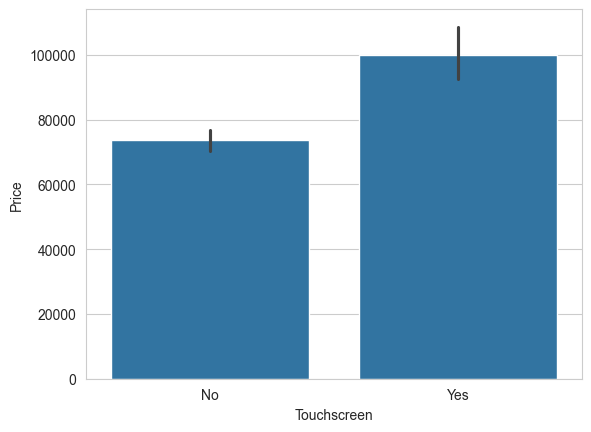

In [21]:
sns.barplot(x = df_train['Touchscreen'], y= df_train['Price'])

### Visualize the Warranty feature

<Axes: xlabel='warranty', ylabel='count'>

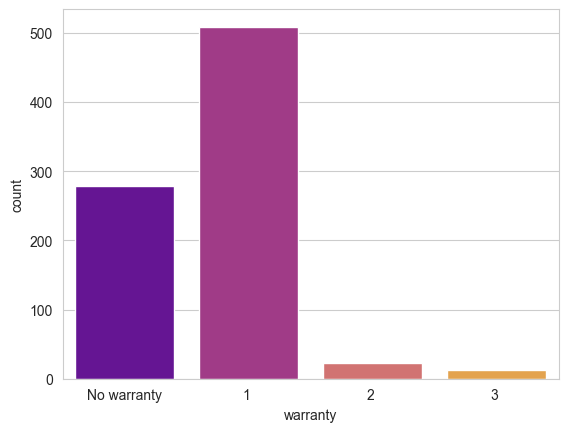

In [22]:
sns.countplot(df_train, x =df_train['warranty'],palette='plasma')

<Axes: xlabel='warranty', ylabel='Price'>

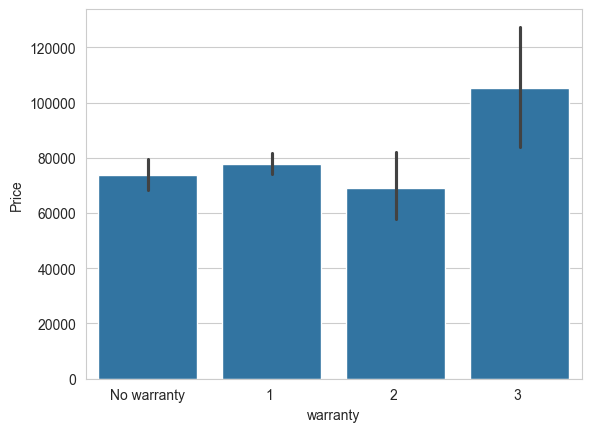

In [23]:
sns.barplot(x = df_train['warranty'], y= df_train['Price'])

### Visualize the Weight feature

<Axes: xlabel='weight', ylabel='count'>

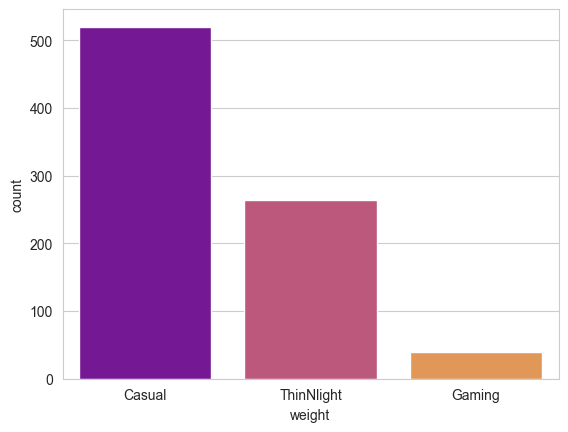

In [24]:
sns.countplot(df_train, x =df_train['weight'],palette='plasma')

<Axes: xlabel='weight', ylabel='Price'>

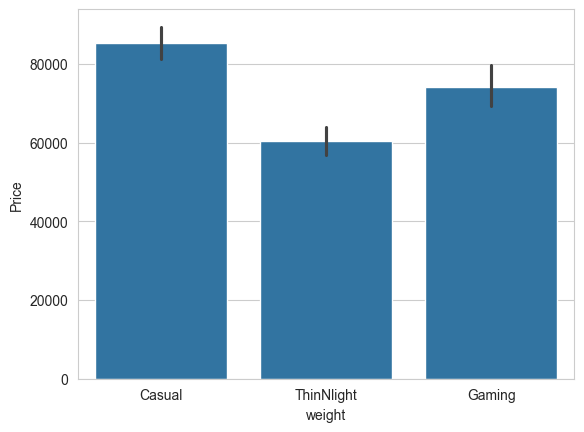

In [25]:
sns.barplot(x = df_train['weight'], y= df_train['Price'])

### Visualize the RAM

<Axes: xlabel='ram_gb', ylabel='count'>

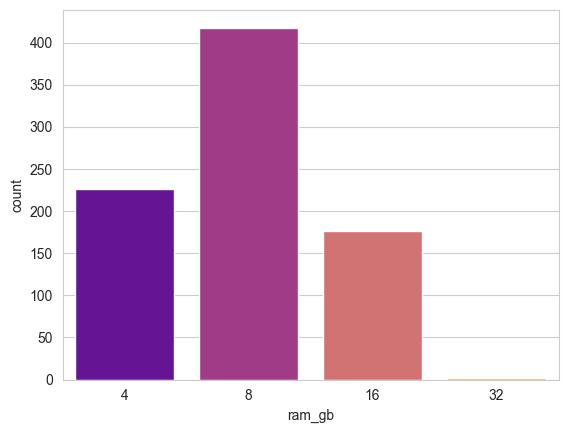

In [26]:
sns.countplot(df_train, x =df_train['ram_gb'],palette='plasma')

<Axes: xlabel='ram_gb', ylabel='Price'>

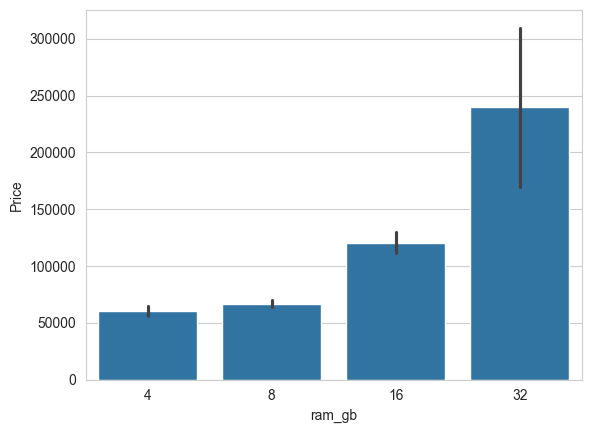

In [27]:
sns.barplot(x = df_train['ram_gb'], y= df_train['Price'])

In [28]:
df_train.sample(10)

,brand,processor_brand,processor_name,processor_gnrtn,ram_gb,ram_type,ssd,hdd,os,os_bit,graphic_card_gb,weight,warranty,Touchscreen,Price
417,acer,Intel,Core i5,11,8,DDR4,0,1024,Windows,64,0,ThinNlight,1,No,46990
686,ASUS,AMD,Ryzen 5,11,8,DDR4,512,0,Windows,64,0,Casual,1,Yes,62450
735,HP,AMD,Ryzen 5,11,4,DDR4,256,1024,Windows,64,4,Gaming,1,No,80000
465,ASUS,Intel,Core i5,10,8,DDR4,256,1024,Windows,32,2,Casual,No warranty,No,58990
57,HP,Intel,Core i3,11,4,DDR4,256,0,Windows,64,0,ThinNlight,1,No,44900
209,DELL,Intel,Core i5,11,8,DDR4,256,0,Windows,64,0,ThinNlight,No warranty,No,55990
537,HP,Intel,Core i7,10,16,DDR4,1024,0,Windows,64,6,Casual,1,No,144690
18,HP,Intel,Celeron Dual,11,8,DDR4,256,0,Windows,64,0,ThinNlight,No warranty,No,32490
725,HP,AMD,Ryzen 5,11,8,DDR4,512,0,Windows,64,4,Gaming,1,No,64990
533,MSI,Intel,Core i7,10,16,DDR4,1024,0,Windows,64,6,Casual,2,No,84990


### Visualize the Operating_system

<Axes: xlabel='os', ylabel='count'>

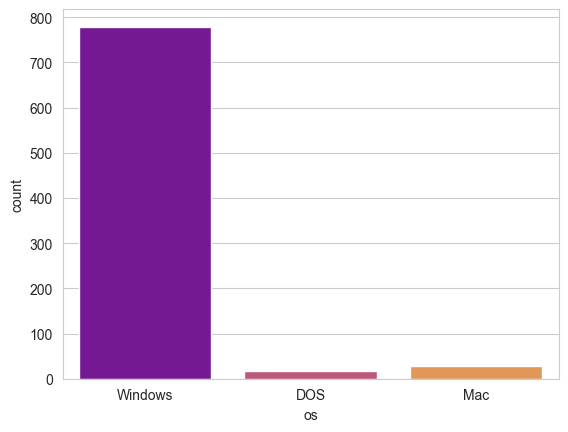

In [29]:
sns.countplot(df_train, x =df_train['os'],palette='plasma')

<Axes: xlabel='os', ylabel='Price'>

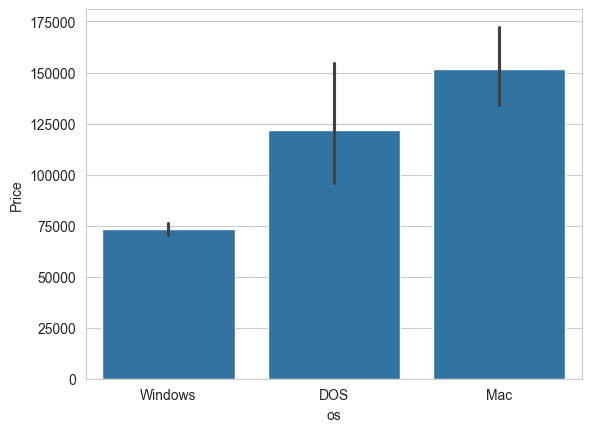

In [30]:
sns.barplot(x = df_train['os'], y= df_train['Price'])

### Visualize the Price

<Axes: xlabel='Price', ylabel='Density'>

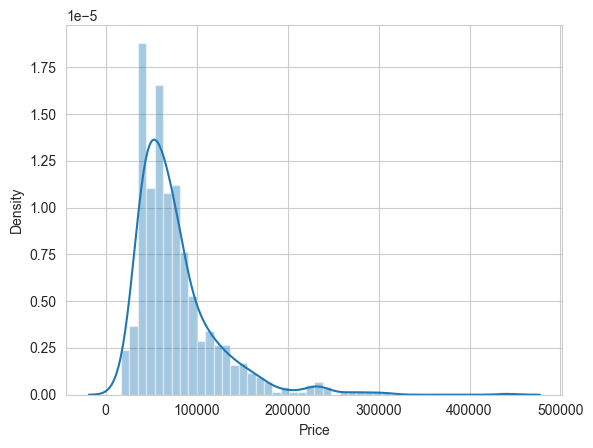

In [31]:
sns.distplot(df_train['Price'])

<Axes: xlabel='Price', ylabel='Density'>

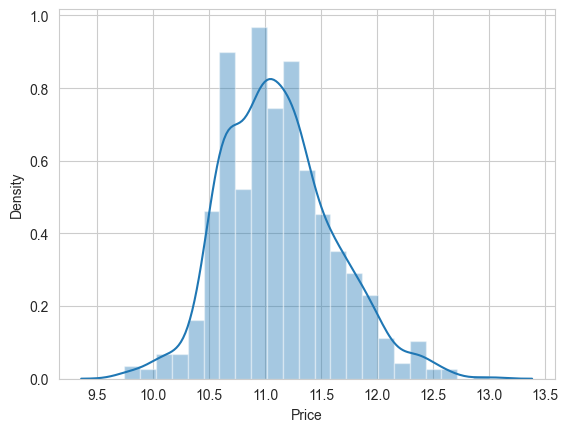

In [32]:
sns.distplot(np.log(df_train['Price']))

In [33]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 823 entries, 0 to 822
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   brand            823 non-null    object
 1   processor_brand  823 non-null    object
 2   processor_name   823 non-null    object
 3   processor_gnrtn  823 non-null    int64 
 4   ram_gb           823 non-null    int32 
 5   ram_type         823 non-null    object
 6   ssd              823 non-null    int32 
 7   hdd              823 non-null    int32 
 8   os               823 non-null    object
 9   os_bit           823 non-null    int32 
 10  graphic_card_gb  823 non-null    int32 
 11  weight           823 non-null    object
 12  warranty         823 non-null    object
 13  Touchscreen      823 non-null    object
 14  Price            823 non-null    int64 
dtypes: int32(5), int64(2), object(8)
memory usage: 80.5+ KB


<Axes: >

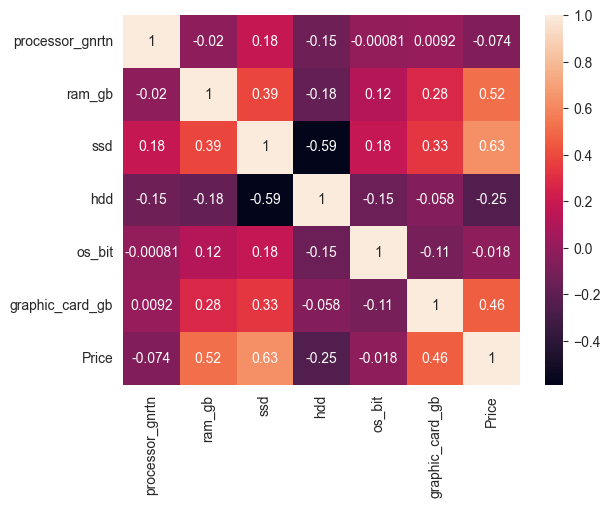

In [34]:
numeric_df = df_train.select_dtypes(include=['number'])
sns.heatmap(numeric_df.corr(), annot=True)

## 4. Final data preps

In [35]:
x = df_train.drop(['Price'], axis=1)
y = np.log(df_train['Price'])

In [36]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=8418)
X_train.shape, X_test.shape

((699, 14), (124, 14))

In [37]:
mapper = {i:value for i,value in enumerate(X_train.columns)}
mapper

{0: 'brand',
 1: 'processor_brand',
 2: 'processor_name',
 3: 'processor_gnrtn',
 4: 'ram_gb',
 5: 'ram_type',
 6: 'ssd',
 7: 'hdd',
 8: 'os',
 9: 'os_bit',
 10: 'graphic_card_gb',
 11: 'weight',
 12: 'warranty',
 13: 'Touchscreen'}

In [38]:
df_train.head()

,brand,processor_brand,processor_name,processor_gnrtn,ram_gb,ram_type,ssd,hdd,os,os_bit,graphic_card_gb,weight,warranty,Touchscreen,Price
0,ASUS,Intel,Core i3,10,4,DDR4,0,1024,Windows,64,0,Casual,No warranty,No,34649
1,Lenovo,Intel,Core i3,10,4,DDR4,0,1024,Windows,64,0,Casual,No warranty,No,38999
2,Lenovo,Intel,Core i3,10,4,DDR4,0,1024,Windows,64,0,Casual,No warranty,No,39999
3,ASUS,Intel,Core i5,10,8,DDR4,512,0,Windows,32,2,Casual,No warranty,No,69990
4,ASUS,Intel,Celeron Dual,11,4,DDR4,0,512,Windows,64,0,Casual,No warranty,No,26990


In [39]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 823 entries, 0 to 822
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   brand            823 non-null    object
 1   processor_brand  823 non-null    object
 2   processor_name   823 non-null    object
 3   processor_gnrtn  823 non-null    int64 
 4   ram_gb           823 non-null    int32 
 5   ram_type         823 non-null    object
 6   ssd              823 non-null    int32 
 7   hdd              823 non-null    int32 
 8   os               823 non-null    object
 9   os_bit           823 non-null    int32 
 10  graphic_card_gb  823 non-null    int32 
 11  weight           823 non-null    object
 12  warranty         823 non-null    object
 13  Touchscreen      823 non-null    object
 14  Price            823 non-null    int64 
dtypes: int32(5), int64(2), object(8)
memory usage: 80.5+ KB


## 5.1 Test Linear Regression method

In [42]:
encoding = ColumnTransformer(transformers = [
    ('col_tnf', OneHotEncoder(sparse_output=False, drop='first'), [0, 1, 2, 5, 8, 11, 12, 13])
], remainder='passthrough')

lr = LinearRegression()

pipe = Pipeline([
    ('encoding', encoding),
    ('lr', lr)
])

pipe.fit(X_train, y_train)

y_train_pred = pipe.predict(X_train)
y_pred = pipe.predict(X_test)

print('Train R2 score', metrics.r2_score(y_train,y_train_pred))
print('Train MAE', metrics.mean_absolute_error(y_train,y_train_pred))
print("Train MAE on the orig price:", np.exp(metrics.mean_absolute_error(y_train,y_train_pred)))
print("Train RMSE on the orig price:", np.exp(metrics.root_mean_squared_error(y_train,y_train_pred)))
print("Train MSE on the orig price:", np.exp(metrics.mean_squared_error(y_train,y_train_pred)), "\n")

print('Test R2 score', metrics.r2_score(y_test,y_pred))
print('Test MAE', metrics.mean_absolute_error(y_test,y_pred))
print("Test MAE on the orig price:", np.exp(metrics.mean_absolute_error(y_test,y_pred)))
print("Test RMSE on the orig price:", np.exp(metrics.root_mean_squared_error(y_test,y_pred)))
print("Test MSE on the orig price:", np.exp(metrics.mean_squared_error(y_test,y_pred)), "\n")

Train R2 score 0.8663048188898103
Train MAE 0.12809545829978325
Train MAE on the orig price: 1.1366615012927748
Train RMSE on the orig price: 1.1933665213991491
Train MSE on the orig price: 1.0317440010987693 

Test R2 score 0.8509808026096805
Test MAE 0.14356278102642966
Test MAE on the orig price: 1.154379281648378
Test RMSE on the orig price: 1.2305226791572403
Test MSE on the orig price: 1.0439702027769238 



# Bayesian Regression

In [44]:
encoding = ColumnTransformer(transformers = [
    ('col_tnf', OneHotEncoder(sparse_output=False, drop='first'), [0, 1, 2, 5, 8, 11, 12, 13])
], remainder='passthrough')

bayes = BayesianRidge()

pipe = Pipeline([
    ('encoding', encoding),
    ('bayes', bayes)
])

pipe.fit(X_train, y_train)

y_train_pred = pipe.predict(X_train)
y_pred = pipe.predict(X_test)

print('Train R2 score', metrics.r2_score(y_train,y_train_pred))
print('Train MAE', metrics.mean_absolute_error(y_train,y_train_pred))
print("Train MAE on the orig price:", np.exp(metrics.mean_absolute_error(y_train,y_train_pred)))
print("Train RMSE on the orig price:", np.exp(metrics.root_mean_squared_error(y_train,y_train_pred)))
print("Train MSE on the orig price:", np.exp(metrics.mean_squared_error(y_train,y_train_pred)), "\n")

print('Test R2 score', metrics.r2_score(y_test,y_pred))
print('Test MAE', metrics.mean_absolute_error(y_test,y_pred))
print("Test MAE on the orig price:", np.exp(metrics.mean_absolute_error(y_test,y_pred)))
print("Test RMSE on the orig price:", np.exp(metrics.root_mean_squared_error(y_test,y_pred)))
print("Test MSE on the orig price:", np.exp(metrics.mean_squared_error(y_test,y_pred)), "\n")

Train R2 score 0.8649355860842717
Train MAE 0.12880107316124345
Train MAE on the orig price: 1.1374638295746269
Train RMSE on the orig price: 1.194444531382335
Train MSE on the orig price: 1.0320742649278554 

Test R2 score 0.8449611286839858
Test MAE 0.1464893601339595
Test MAE on the orig price: 1.1577626123138212
Test RMSE on the orig price: 1.2356378607376977
Test MSE on the orig price: 1.0457864596507775 



## 5.2 Test Lasso Regression

In [45]:
encoding = ColumnTransformer(transformers = [
    ('col_tnf', OneHotEncoder(sparse_output=False, drop='first'), [0, 1, 2, 5, 8, 11, 12, 13])
], remainder='passthrough')

lasso = Lasso(alpha=0.001)

pipe = Pipeline([
    ('encoding', encoding),
    ('lasso', lasso)
])

pipe.fit(X_train, y_train)

y_train_pred = pipe.predict(X_train)
y_pred = pipe.predict(X_test)

print('Train R2 score', metrics.r2_score(y_train,y_train_pred))
print('Train MAE', metrics.mean_absolute_error(y_train,y_train_pred))
print("Train MAE on the orig price:", np.exp(metrics.mean_absolute_error(y_train,y_train_pred)))
print("Train RMSE on the orig price:", np.exp(metrics.root_mean_squared_error(y_train,y_train_pred)))
print("Train MSE on the orig price:", np.exp(metrics.mean_squared_error(y_train,y_train_pred)), "\n")

print('Test R2 score', metrics.r2_score(y_test,y_pred))
print('Test MAE', metrics.mean_absolute_error(y_test,y_pred))
print("Test MAE on the orig price:", np.exp(metrics.mean_absolute_error(y_test,y_pred)))
print("Test RMSE on the orig price:", np.exp(metrics.root_mean_squared_error(y_test,y_pred)))
print("Test MSE on the orig price:", np.exp(metrics.mean_squared_error(y_test,y_pred)), "\n")

Train R2 score 0.8539145775181127
Train MAE 0.1343102892681184
Train MAE on the orig price: 1.143747657214124
Train RMSE on the orig price: 1.2029637979756893
Train MSE on the orig price: 1.0347364243934019 

Test R2 score 0.8227381157196224
Test MAE 0.15846844070149596
Test MAE on the orig price: 1.1717149451399707
Test RMSE on the orig price: 1.2538815459758772
Test MSE on the orig price: 1.0525189982869523 



## 5.3. Decision Tree

In [46]:
encoding = ColumnTransformer(transformers = [
    ('col_tnf', OneHotEncoder(sparse_output=False, drop='first'), [0, 1, 2, 5, 8, 11, 12, 13])
], remainder='passthrough')

dtr = DecisionTreeRegressor(max_depth=8)

pipe = Pipeline([
    ('encoding', encoding),
    ('dtr', dtr)
])

pipe.fit(X_train, y_train)

y_train_pred = pipe.predict(X_train)
y_pred = pipe.predict(X_test)

print('Train R2 score', metrics.r2_score(y_train,y_train_pred))
print('Train MAE', metrics.mean_absolute_error(y_train,y_train_pred))
print("Train MAE on the orig price:", np.exp(metrics.mean_absolute_error(y_train,y_train_pred)), "\n")

print('Test R2 score', metrics.r2_score(y_test,y_pred))
print('Test MAE', metrics.mean_absolute_error(y_test,y_pred))
print("Test MAE on the orig price:", np.exp(metrics.mean_absolute_error(y_test,y_pred)))

Train R2 score 0.8929483768816412
Train MAE 0.10792686622351404
Train MAE on the orig price: 1.1139662738468588 

Test R2 score 0.795922270050249
Test MAE 0.1683954111668489
Test MAE on the orig price: 1.1834044494815894


## 5.4. Random Forest

In [47]:
encoding = ColumnTransformer(transformers = [
    ('col_tnf', OneHotEncoder(sparse_output=False, drop='first'), [0, 1, 2, 5, 8, 11, 12, 13])
], remainder='passthrough')

random = RandomForestRegressor(n_estimators=100,
                              random_state=3,
                              max_samples=0.5,
                              max_features=0.75,
                              max_depth=15)

pipe = Pipeline([
    ('encoding', encoding),
    ('random', random)
])

pipe.fit(X_train, y_train)

y_train_pred = pipe.predict(X_train)
y_pred = pipe.predict(X_test)

print('Train R2 score', metrics.r2_score(y_train,y_train_pred))
print('Train MAE', metrics.mean_absolute_error(y_train,y_train_pred))
print("Train MAE on the orig price:", np.exp(metrics.mean_absolute_error(y_train,y_train_pred)), "\n")

print('Test R2 score', metrics.r2_score(y_test,y_pred))
print('Test MAE', metrics.mean_absolute_error(y_test,y_pred))
print("Test MAE on the orig price:", np.exp(metrics.mean_absolute_error(y_test,y_pred)))

Train R2 score 0.9350059476104549
Train MAE 0.08463718344688273
Train MAE on the orig price: 1.0883221337733728 

Test R2 score 0.8583367845839139
Test MAE 0.14201903920592035
Test MAE on the orig price: 1.1525985928900564


## 5.4.1 You can also tune hyperparameters of Random Forest

In [48]:
indexlist = [0, 1, 2, 5, 8, 11, 12, 13]
transformlist = []
for key,value in mapper.items():
    if key in indexlist:
        transformlist.append(value)
        
transformlist

['brand',
 'processor_brand',
 'processor_name',
 'ram_type',
 'os',
 'weight',
 'warranty',
 'Touchscreen']

In [49]:
x = pd.get_dummies(x,columns=transformlist,drop_first=True)
x.head()

,processor_gnrtn,ram_gb,ssd,hdd,os_bit,graphic_card_gb,brand_ASUS,brand_Avita,brand_DELL,brand_HP,...,ram_type_LPDDR4,ram_type_LPDDR4X,os_Mac,os_Windows,weight_Gaming,weight_ThinNlight,warranty_2,warranty_3,warranty_No warranty,Touchscreen_Yes
0,10,4,0,1024,64,0,True,False,False,False,...,False,False,False,True,False,False,False,False,True,False
1,10,4,0,1024,64,0,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
2,10,4,0,1024,64,0,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
3,10,8,512,0,32,2,True,False,False,False,...,False,False,False,True,False,False,False,False,True,False
4,11,4,0,512,64,0,True,False,False,False,...,False,False,False,True,False,False,False,False,True,False


In [50]:
X_train, X_test, y_train, y_test = train_test_split(x,y,
                                                   test_size=0.15,random_state=4818)

X_train.shape,X_test.shape

((699, 38), (124, 38))

In [51]:
rfr = RandomForestRegressor()

In [52]:
param_grid = { 
            "n_estimators"      : [10,20,30],
            "max_features"      : ["sqrt", "log2"],
            "min_samples_split" : [2,4,8],
            "bootstrap": [True, False],
            }

In [53]:
grid_search = GridSearchCV(rfr, param_grid, cv=5, scoring='r2')

In [54]:
grid_search.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'bootstrap': [True, False],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_split': [2, 4, 8],
                         'n_estimators': [10, 20, 30]},
             scoring='r2')

In [55]:
print('Best hyper parameter :' , grid_search.best_params_)
print('Best model :' , grid_search.best_estimator_)

Best hyper parameter : {'bootstrap': False, 'max_features': 'log2', 'min_samples_split': 4, 'n_estimators': 30}
Best model : RandomForestRegressor(bootstrap=False, max_features='log2', min_samples_split=4,
                      n_estimators=30)


In [56]:
rfr =  RandomForestRegressor(bootstrap=False, max_features='log2', min_samples_split=4,
                      n_estimators=30)

In [57]:
rf_grid = rfr.fit(X_train,y_train)

In [58]:
y_train_pred = rf_grid.predict(X_train)
y_pred = rf_grid.predict(X_test)

print('Train R2 score', metrics.r2_score(y_train,y_train_pred))
print('Train MAE', metrics.mean_absolute_error(y_train,y_train_pred))
print("Train MAE on the orig price:", np.exp(metrics.mean_absolute_error(y_train,y_train_pred)), "\n")

print('Test R2 score', metrics.r2_score(y_test,y_pred))
print('Test MAE', metrics.mean_absolute_error(y_test,y_pred))
print("Test MAE on the orig price:", np.exp(metrics.mean_absolute_error(y_test,y_pred)))

Train R2 score 0.9703217123826874
Train MAE 0.05791470933317571
Train MAE on the orig price: 1.0596246157659974 

Test R2 score 0.8677414841959912
Test MAE 0.12529802428612247
Test MAE on the orig price: 1.1334862091528806


In [59]:
predicted = []
testtrain = np.array(x)
for i in range(len(testtrain)):
    predicted.append(rfr.predict([testtrain[i]]))
    
predicted

[array([10.50365528]),
 array([10.57812194]),
 array([10.57812194]),
 array([11.19708112]),
 array([10.09628365]),
 array([10.09628365]),
 array([10.01298249]),
 array([11.04764097]),
 array([10.75076943]),
 array([11.08620029]),
 array([11.30436366]),
 array([11.08620029]),
 array([9.8614634]),
 array([10.09628365]),
 array([10.5818138]),
 array([10.91019345]),
 array([11.14476027]),
 array([10.41931207]),
 array([10.4741689]),
 array([10.41931207]),
 array([10.39142832]),
 array([10.43821466]),
 array([10.4685748]),
 array([10.80254923]),
 array([10.48514526]),
 array([10.56259357]),
 array([10.5343704]),
 array([10.48544806]),
 array([10.61912981]),
 array([10.61710499]),
 array([10.91019345]),
 array([10.56035993]),
 array([10.55030362]),
 array([10.64323869]),
 array([10.60421065]),
 array([10.54125804]),
 array([10.68982236]),
 array([10.64323869]),
 array([10.60421065]),
 array([10.65692835]),
 array([10.59060387]),
 array([10.89838761]),
 array([10.53908524]),
 array([10.598552

In [60]:
ans = [np.exp(predicted[i][0]) for i in range(len(predicted))]

In [61]:
rounded_prices = [round(pred) for pred in ans]

In [62]:
df_train['Predicted Price'] = np.array(rounded_prices)
df_train

,brand,processor_brand,processor_name,processor_gnrtn,ram_gb,ram_type,ssd,hdd,os,os_bit,graphic_card_gb,weight,warranty,Touchscreen,Price,Predicted Price
0,ASUS,Intel,Core i3,10,4,DDR4,0,1024,Windows,64,0,Casual,No warranty,No,34649,36448
1,Lenovo,Intel,Core i3,10,4,DDR4,0,1024,Windows,64,0,Casual,No warranty,No,38999,39266
2,Lenovo,Intel,Core i3,10,4,DDR4,0,1024,Windows,64,0,Casual,No warranty,No,39999,39266
3,ASUS,Intel,Core i5,10,8,DDR4,512,0,Windows,32,2,Casual,No warranty,No,69990,72917
4,ASUS,Intel,Celeron Dual,11,4,DDR4,0,512,Windows,64,0,Casual,No warranty,No,26990,24253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
818,ASUS,AMD,Ryzen 9,11,4,DDR4,1024,0,Windows,64,0,Casual,1,No,135990,127440
819,ASUS,AMD,Ryzen 9,11,4,DDR4,1024,0,Windows,64,0,Casual,1,No,144990,127440
820,ASUS,AMD,Ryzen 9,11,4,DDR4,1024,0,Windows,64,4,Casual,1,No,149990,151767
821,ASUS,AMD,Ryzen 9,11,4,DDR4,1024,0,Windows,64,4,Casual,1,No,142990,151767


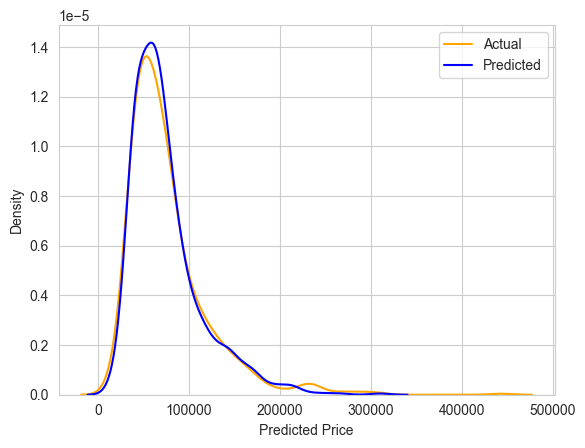

In [63]:
sns.distplot(df_train['Price'],hist=False,color='orange',label='Actual')
sns.distplot(df_train['Predicted Price'],hist=False,color='blue',label='Predicted')
plt.legend()
plt.show()

<Axes: xlabel='Price', ylabel='Predicted Price'>

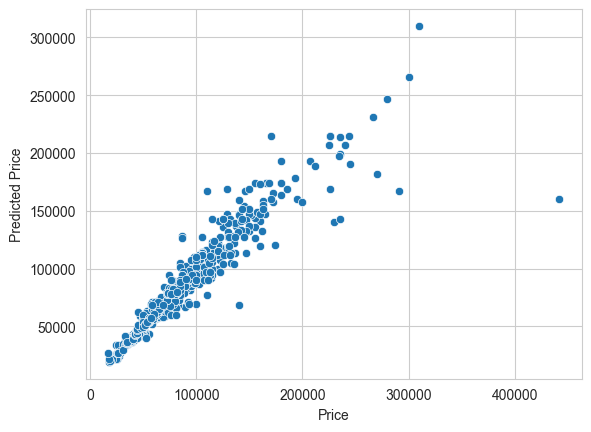

In [64]:
sns.scatterplot(df_train, x="Price", y="Predicted Price")

In [65]:
df_train["log(Price)"] = np.log(df_train["Price"])
df_train["log(Pred_Price)"] = np.log(df_train["Predicted Price"])

<Axes: xlabel='log(Price)', ylabel='log(Pred_Price)'>

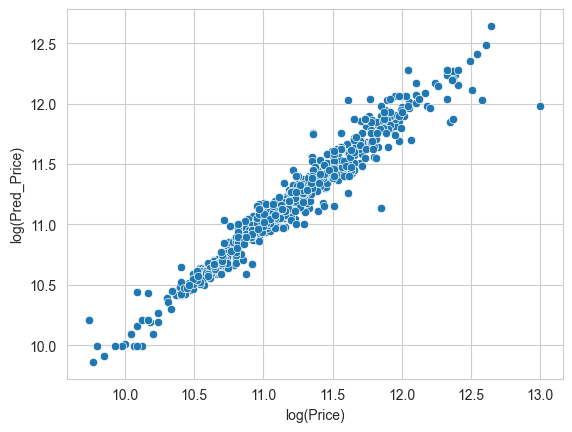

In [66]:
sns.scatterplot(df_train, x="log(Price)", y="log(Pred_Price)")

# The lab work task
Solve the regression problem for the one of the presented datasets using the same steps into your work.
To get you variant: (your_num % 9), where your_num is your number in the group list.

In addition to presented in the example methods consider other ML methods like Support Vector Machine, Gradient Boosting Regression, Bayesian Ridge Regression.

Present your work in the Jupyter Notebook variant

P.s. in provided data sources you can find examples of solving this problem, but be ready to explain the code and results.

# Data to choose
0. [Gold Price Prediction](https://www.kaggle.com/datasets/franciscogcc/financial-data)
1. [Possum Regression](https://www.kaggle.com/datasets/abrambeyer/openintro-possum/data)
2. [Student Performance](https://www.kaggle.com/datasets/nikhil7280/student-performance-multiple-linear-regression)
3. [Boston House Prices](https://www.kaggle.com/datasets/fedesoriano/the-boston-houseprice-data/data)
4. [Car Price](https://www.kaggle.com/datasets/hellbuoy/car-price-prediction)
5. [Medical Cost](https://www.kaggle.com/datasets/mirichoi0218/insurance)
6. [Crab Age Prediction](https://www.kaggle.com/datasets/sidhus/crab-age-prediction)
7. [Calculate Concrete Strength](https://www.kaggle.com/datasets/prathamtripathi/regression-with-neural-networking)
8. [Advertising dataset](https://www.kaggle.com/datasets/tawfikelmetwally/advertising-dataset)

In [2]:
import os

import numpy as np  # linear algebra
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings

warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn import tree

from sklearn.model_selection import GridSearchCV


In [3]:
df = pd.read_csv("./src/CarPrice_Assignment.csv")
df.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [4]:
df.columns

Index(['car_ID', 'symboling', 'CarName', 'fueltype', 'aspiration',
       'doornumber', 'carbody', 'drivewheel', 'enginelocation', 'wheelbase',
       'carlength', 'carwidth', 'carheight', 'curbweight', 'enginetype',
       'cylindernumber', 'enginesize', 'fuelsystem', 'boreratio', 'stroke',
       'compressionratio', 'horsepower', 'peakrpm', 'citympg', 'highwaympg',
       'price'],
      dtype='object')

In [5]:
selected_columns = [
    'fueltype', 'aspiration', 'carbody', 'drivewheel', 'enginelocation',
    'wheelbase', 'carlength', 'carwidth', 'carheight', 'curbweight',
    'enginetype', 'cylindernumber', 'enginesize', 'boreratio', 'stroke',
    'compressionratio', 'horsepower', 'peakrpm', 'citympg', 'highwaympg',
    'price'
]

df_train = df[selected_columns]

In [6]:
print(df_train.isnull().sum())

fueltype            0
aspiration          0
carbody             0
drivewheel          0
enginelocation      0
wheelbase           0
carlength           0
carwidth            0
carheight           0
curbweight          0
enginetype          0
cylindernumber      0
enginesize          0
boreratio           0
stroke              0
compressionratio    0
horsepower          0
peakrpm             0
citympg             0
highwaympg          0
price               0
dtype: int64


In [7]:
df_train.duplicated().sum()

np.int64(2)

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   fueltype          205 non-null    object 
 1   aspiration        205 non-null    object 
 2   carbody           205 non-null    object 
 3   drivewheel        205 non-null    object 
 4   enginelocation    205 non-null    object 
 5   wheelbase         205 non-null    float64
 6   carlength         205 non-null    float64
 7   carwidth          205 non-null    float64
 8   carheight         205 non-null    float64
 9   curbweight        205 non-null    int64  
 10  enginetype        205 non-null    object 
 11  cylindernumber    205 non-null    object 
 12  enginesize        205 non-null    int64  
 13  boreratio         205 non-null    float64
 14  stroke            205 non-null    float64
 15  compressionratio  205 non-null    float64
 16  horsepower        205 non-null    int64  
 1

In [9]:
cat_val = df_train.select_dtypes(include=['object']).columns
num_val = df_train.select_dtypes(include=['int', "float"]).columns

print(cat_val,'\n',num_val)

Index(['fueltype', 'aspiration', 'carbody', 'drivewheel', 'enginelocation',
       'enginetype', 'cylindernumber'],
      dtype='object') 
 Index(['wheelbase', 'carlength', 'carwidth', 'carheight', 'curbweight',
       'enginesize', 'boreratio', 'stroke', 'compressionratio', 'horsepower',
       'peakrpm', 'citympg', 'highwaympg', 'price'],
      dtype='object')


In [10]:
for column in df_train.columns:
    unique_values = df_train[column].unique()
    print(f"Unique values in column '{column}': {unique_values}")

Unique values in column 'fueltype': ['gas' 'diesel']
Unique values in column 'aspiration': ['std' 'turbo']
Unique values in column 'carbody': ['convertible' 'hatchback' 'sedan' 'wagon' 'hardtop']
Unique values in column 'drivewheel': ['rwd' 'fwd' '4wd']
Unique values in column 'enginelocation': ['front' 'rear']
Unique values in column 'wheelbase': [ 88.6  94.5  99.8  99.4 105.8  99.5 101.2 103.5 110.   88.4  93.7 103.3
  95.9  86.6  96.5  94.3  96.  113.  102.   93.1  95.3  98.8 104.9 106.7
 115.6  96.6 120.9 112.  102.7  93.   96.3  95.1  97.2 100.4  91.3  99.2
 107.9 114.2 108.   89.5  98.4  96.1  99.1  93.3  97.   96.9  95.7 102.4
 102.9 104.5  97.3 104.3 109.1]
Unique values in column 'carlength': [168.8 171.2 176.6 177.3 192.7 178.2 176.8 189.  193.8 197.  141.1 155.9
 158.8 157.3 174.6 173.2 144.6 150.  163.4 157.1 167.5 175.4 169.1 170.7
 172.6 199.6 191.7 159.1 166.8 169.  177.8 175.  190.9 187.5 202.6 180.3
 208.1 199.2 178.4 173.  172.4 165.3 170.2 165.6 162.4 173.4 181.7 184

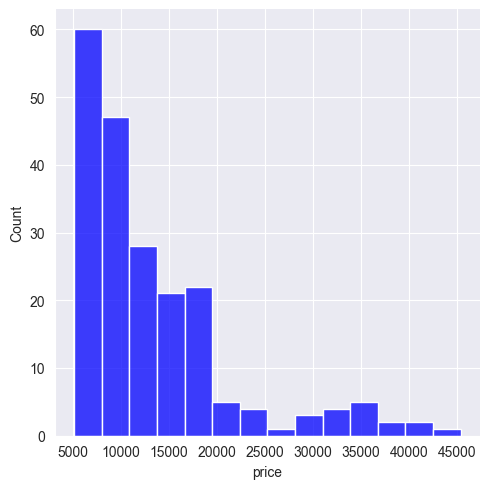

In [11]:
sns.displot(df['price'],color='blue')

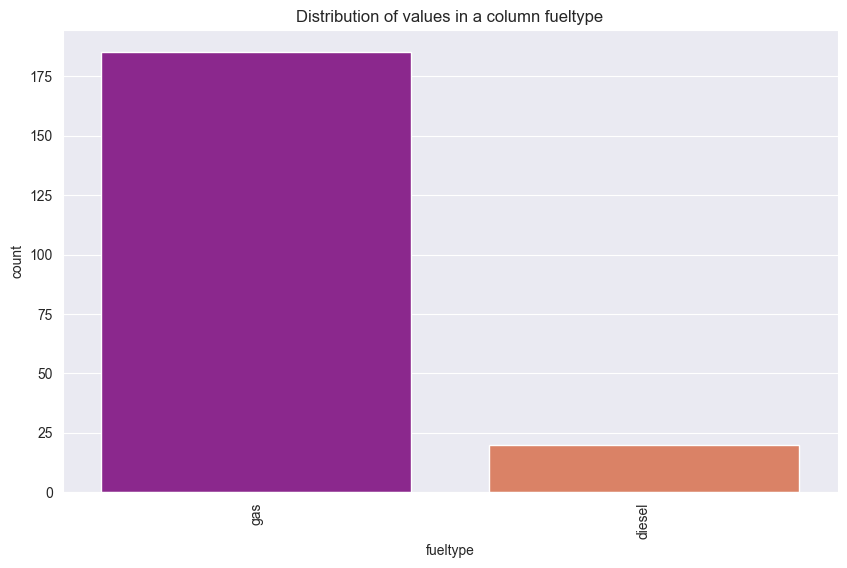

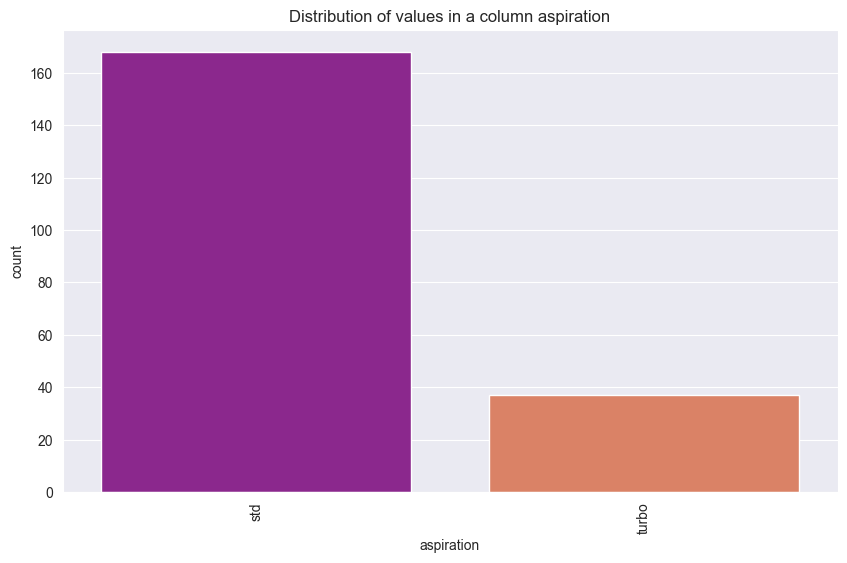

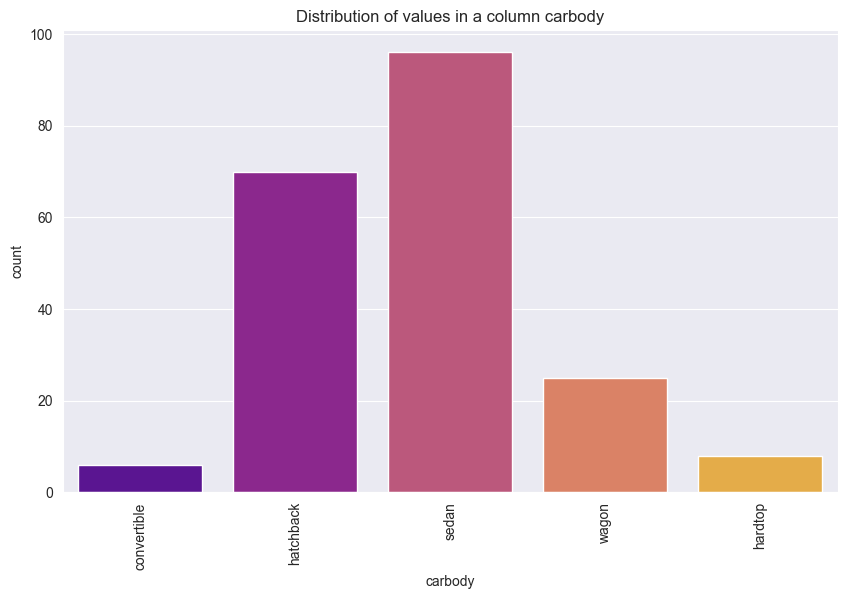

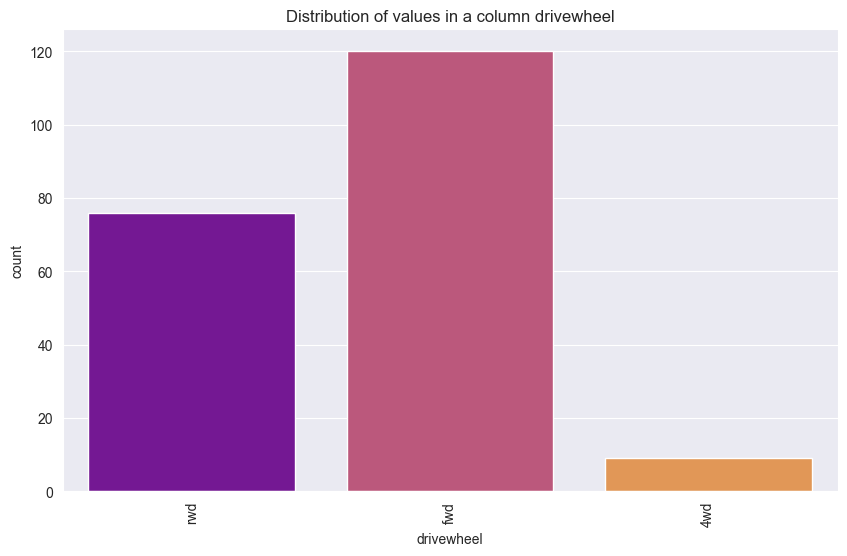

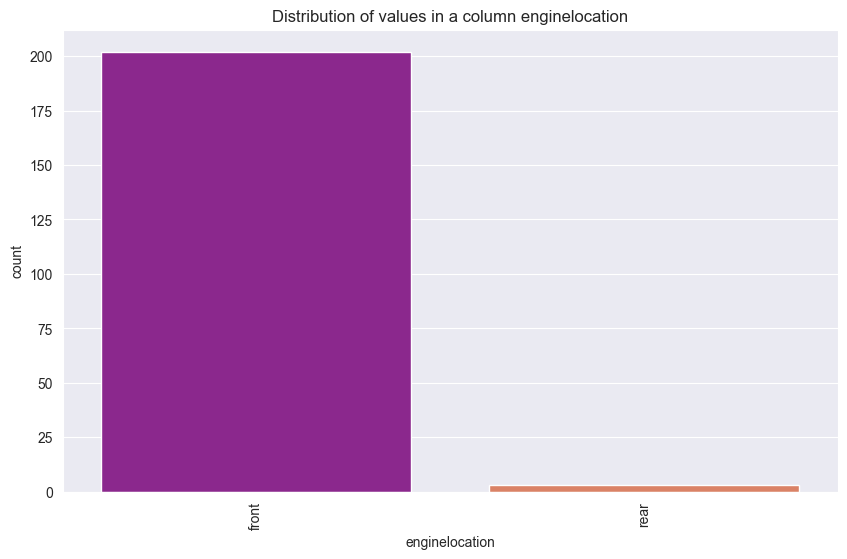

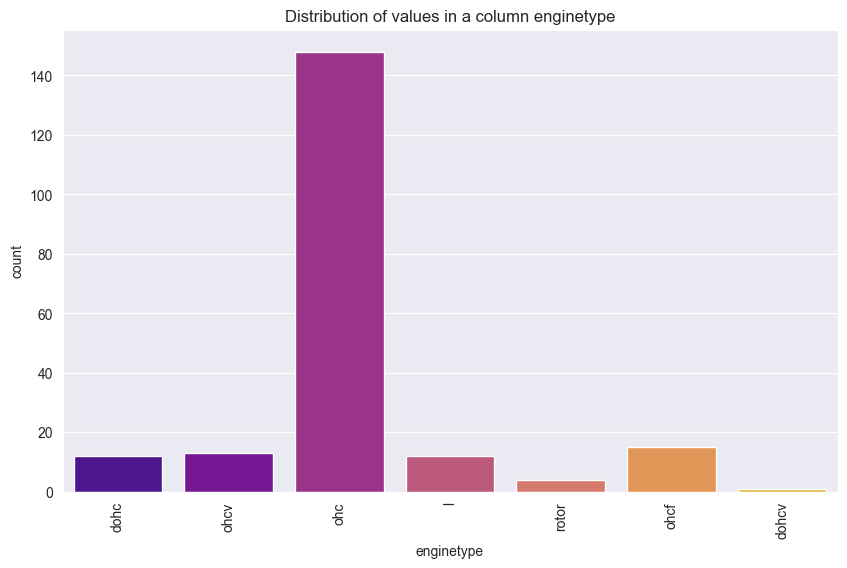

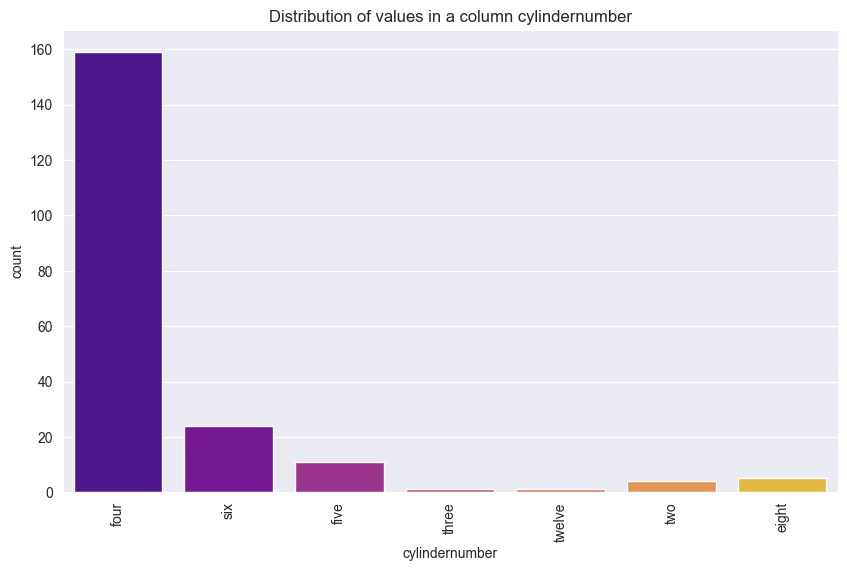

In [13]:

def dataplot(col):
    plt.figure(figsize=(10,6))
    sns.countplot(data=df_train, x=col, palette='plasma')
    plt.xticks(rotation='vertical')
    plt.title(f"Distribution of values in a column {col}")
    plt.show()

cat_val = df_train.select_dtypes(include=['object']).columns

for col in cat_val:
    dataplot(col)

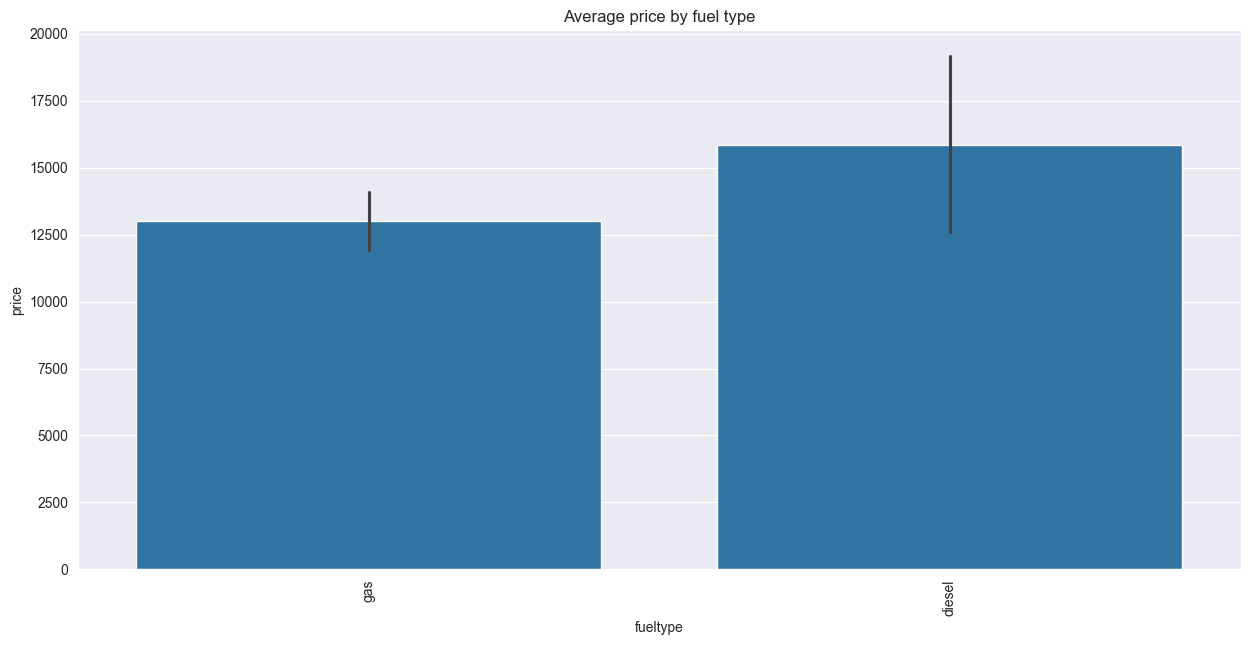

In [14]:
plt.figure(figsize=(15,7))
sns.barplot(x=df_train['fueltype'], y=df_train['price'])
plt.xticks(rotation='vertical')
plt.title("Average price by fuel type")
plt.show()

<Axes: xlabel='fueltype', ylabel='count'>

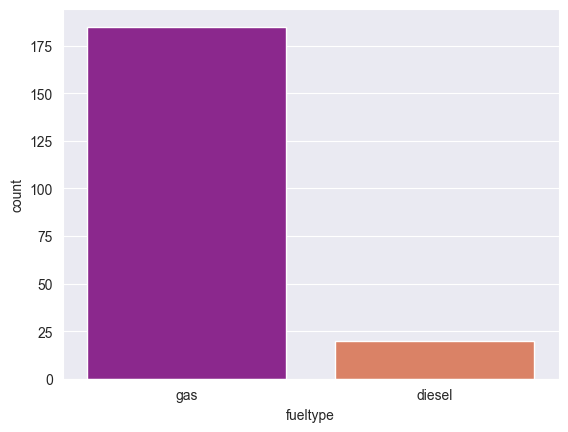

In [15]:
sns.countplot(data=df_train, x='fueltype', palette='plasma')

<Axes: xlabel='fueltype', ylabel='price'>

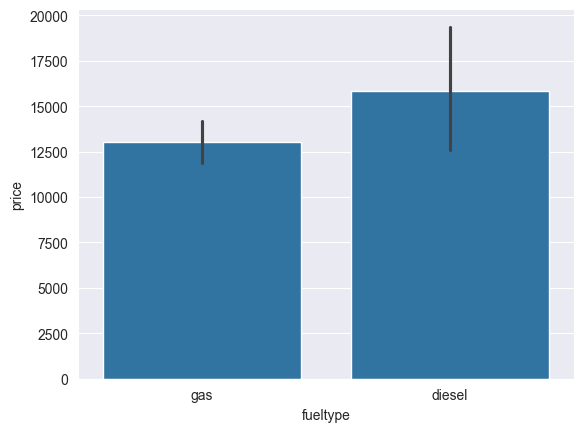

In [17]:
sns.barplot(x = df_train['fueltype'], y= df_train['price'])

<Axes: xlabel='enginetype', ylabel='count'>

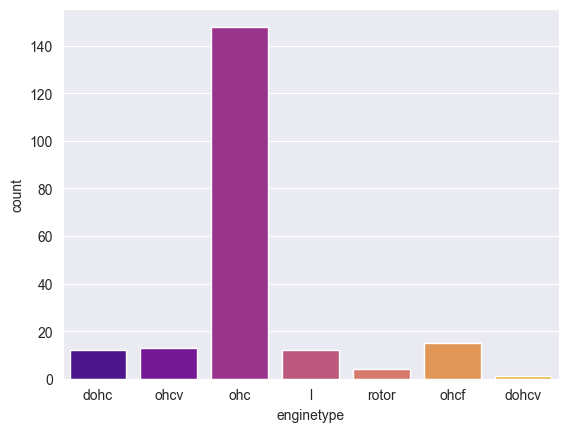

In [20]:
sns.countplot(df_train, x =df_train['enginetype'],palette='plasma')

<Axes: xlabel='enginesize_bin', ylabel='count'>

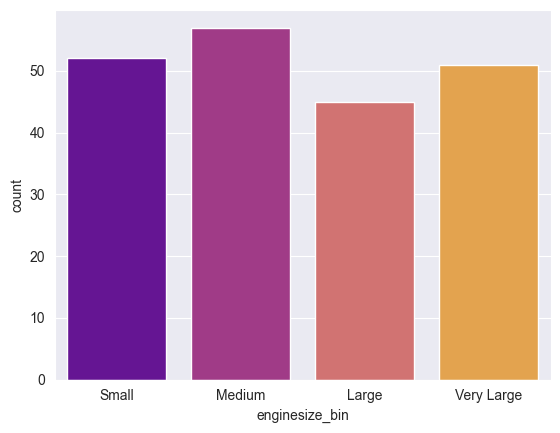

In [21]:
df_train['enginesize_bin'] = pd.qcut(df_train['enginesize'], q=4, labels=['Small', 'Medium', 'Large', 'Very Large'])

sns.countplot(data=df_train, x='enginesize_bin', palette='plasma')

<Axes: xlabel='curbweight_bin', ylabel='count'>

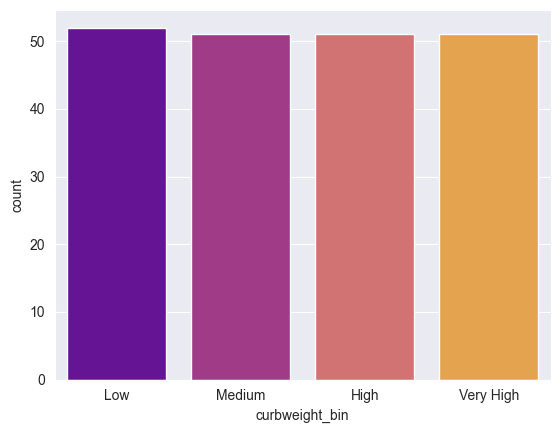

In [22]:
df_train['curbweight_bin'] = pd.qcut(df_train['curbweight'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])

sns.countplot(data=df_train, x='curbweight_bin', palette='plasma')

<Axes: xlabel='curbweight_bin', ylabel='price'>

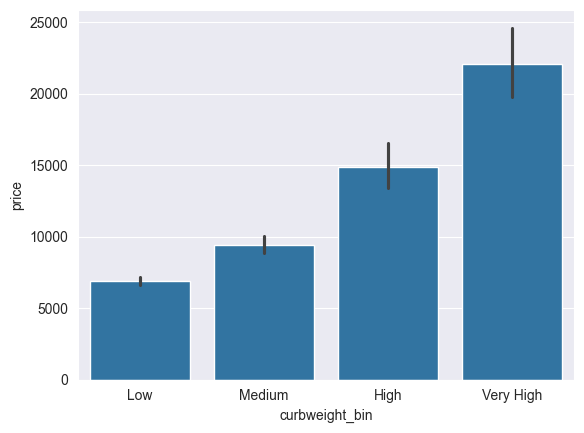

In [23]:
sns.barplot(x = df_train['curbweight_bin'], y= df_train['price'])

In [24]:
df_train.sample(10)

,fueltype,aspiration,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,...,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price,enginesize_bin,curbweight_bin
21,gas,std,hatchback,fwd,front,93.7,157.3,63.8,50.8,1876,...,2.97,3.230,9.41,68,5500,37,41,5572.0,Small,Low
92,gas,std,sedan,fwd,front,94.5,165.3,63.8,54.5,1938,...,3.15,3.290,9.40,69,5200,31,37,6849.0,Small,Low
11,gas,std,sedan,rwd,front,101.2,176.8,64.8,54.3,2395,...,3.50,2.800,8.80,101,5800,23,29,16925.0,Medium,Medium
56,gas,std,hatchback,rwd,front,95.3,169.0,65.7,49.6,2380,...,3.33,3.255,9.40,101,6000,17,23,11845.0,Small,Medium
3,gas,std,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,...,3.19,3.400,10.00,102,5500,24,30,13950.0,Medium,Medium
22,gas,std,hatchback,fwd,front,93.7,157.3,63.8,50.8,1876,...,2.97,3.230,9.40,68,5500,31,38,6377.0,Small,Low
109,gas,std,wagon,rwd,front,114.2,198.9,68.4,58.7,3230,...,3.46,3.190,8.40,97,5000,19,24,12440.0,Medium,Very High
161,gas,std,hatchback,fwd,front,95.7,166.3,64.4,52.8,2122,...,3.19,3.030,9.00,70,4800,28,34,8358.0,Medium,Low
81,gas,std,hatchback,fwd,front,96.3,173.0,65.4,49.4,2328,...,3.35,3.460,8.50,88,5000,25,32,8499.0,Large,Medium
179,gas,std,hatchback,rwd,front,102.9,183.5,67.7,52.0,3016,...,3.27,3.350,9.30,161,5200,19,24,15998.0,Very Large,Very High


<Axes: xlabel='price', ylabel='Density'>

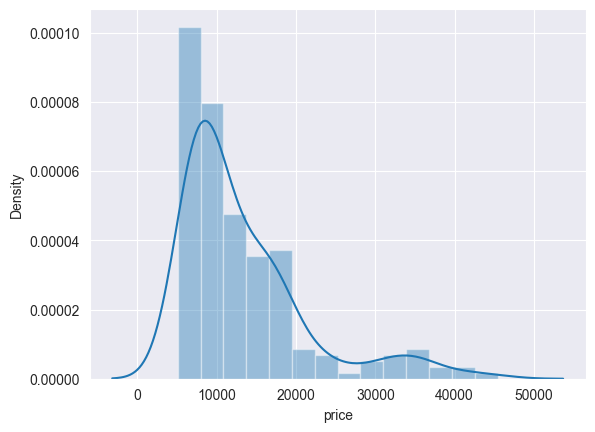

In [27]:
sns.distplot(df_train['price'])

<Axes: xlabel='price', ylabel='Density'>

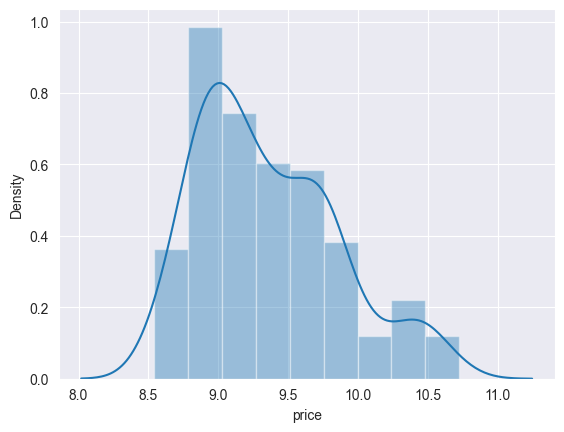

In [29]:
sns.distplot(np.log(df_train['price']))

In [30]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   fueltype          205 non-null    object  
 1   aspiration        205 non-null    object  
 2   carbody           205 non-null    object  
 3   drivewheel        205 non-null    object  
 4   enginelocation    205 non-null    object  
 5   wheelbase         205 non-null    float64 
 6   carlength         205 non-null    float64 
 7   carwidth          205 non-null    float64 
 8   carheight         205 non-null    float64 
 9   curbweight        205 non-null    int64   
 10  enginetype        205 non-null    object  
 11  cylindernumber    205 non-null    object  
 12  enginesize        205 non-null    int64   
 13  boreratio         205 non-null    float64 
 14  stroke            205 non-null    float64 
 15  compressionratio  205 non-null    float64 
 16  horsepower        205 non-

<Axes: >

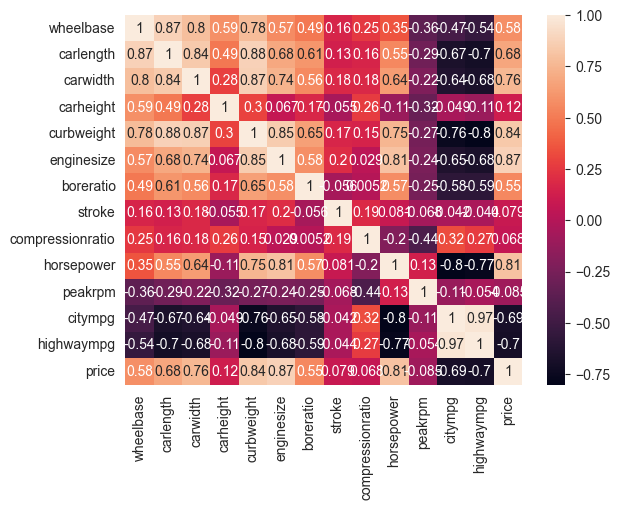

In [31]:
numeric_df = df_train.select_dtypes(include=['number'])
sns.heatmap(numeric_df.corr(), annot=True)

In [33]:
x = df_train.drop(['price'], axis=1)
y = np.log(df_train['price'])

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=8418)
X_train.shape, X_test.shape

((174, 22), (31, 22))

In [34]:
mapper = {i:value for i,value in enumerate(X_train.columns)}
mapper

{0: 'fueltype',
 1: 'aspiration',
 2: 'carbody',
 3: 'drivewheel',
 4: 'enginelocation',
 5: 'wheelbase',
 6: 'carlength',
 7: 'carwidth',
 8: 'carheight',
 9: 'curbweight',
 10: 'enginetype',
 11: 'cylindernumber',
 12: 'enginesize',
 13: 'boreratio',
 14: 'stroke',
 15: 'compressionratio',
 16: 'horsepower',
 17: 'peakrpm',
 18: 'citympg',
 19: 'highwaympg',
 20: 'enginesize_bin',
 21: 'curbweight_bin'}

In [35]:
df_train.head()

,fueltype,aspiration,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,...,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price,enginesize_bin,curbweight_bin
0,gas,std,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,...,3.47,2.68,9.0,111,5000,21,27,13495.0,Large,High
1,gas,std,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,...,3.47,2.68,9.0,111,5000,21,27,16500.0,Large,High
2,gas,std,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,...,2.68,3.47,9.0,154,5000,19,26,16500.0,Very Large,High
3,gas,std,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,...,3.19,3.40,10.0,102,5500,24,30,13950.0,Medium,Medium
4,gas,std,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,...,3.19,3.40,8.0,115,5500,18,22,17450.0,Large,High


In [36]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   fueltype          205 non-null    object  
 1   aspiration        205 non-null    object  
 2   carbody           205 non-null    object  
 3   drivewheel        205 non-null    object  
 4   enginelocation    205 non-null    object  
 5   wheelbase         205 non-null    float64 
 6   carlength         205 non-null    float64 
 7   carwidth          205 non-null    float64 
 8   carheight         205 non-null    float64 
 9   curbweight        205 non-null    int64   
 10  enginetype        205 non-null    object  
 11  cylindernumber    205 non-null    object  
 12  enginesize        205 non-null    int64   
 13  boreratio         205 non-null    float64 
 14  stroke            205 non-null    float64 
 15  compressionratio  205 non-null    float64 
 16  horsepower        205 non-

In [ ]:
cat_cols = X_train.select_dtypes(include='object').columns
cat_indices = [X_train.columns.get_loc(col) for col in cat_cols]

encoding = ColumnTransformer(transformers=[
    ('col_tnf', OneHotEncoder(sparse_output=False, drop='first'), cat_indices)
], remainder='passthrough')

lr = LinearRegression()

pipe = Pipeline([
    ('encoding', encoding),
    ('lr', lr)
])

pipe.fit(X_train, y_train)

y_train_pred = pipe.predict(X_train)
y_pred = pipe.predict(X_test)

print('Train R2 score', metrics.r2_score(y_train, y_train_pred))
print('Train MAE', metrics.mean_absolute_error(y_train, y_train_pred))
print("Train MAE on the orig price:", np.exp(metrics.mean_absolute_error(y_train, y_train_pred)))
print("Train RMSE on the orig price:", np.exp(metrics.mean_squared_error(y_train, y_train_pred)**0.5))
print("Train MSE on the orig price:", np.exp(metrics.mean_squared_error(y_train, y_train_pred)), "\n")

print('Test R2 score', metrics.r2_score(y_test, y_pred))
print('Test MAE', metrics.mean_absolute_error(y_test, y_pred))
print("Test MAE on the orig price:", np.exp(metrics.mean_absolute_error(y_test, y_pred)))
print("Test RMSE on the orig price:", np.exp(metrics.mean_squared_error(y_test, y_pred)**0.5))
print("Test MSE on the orig price:", np.exp(metrics.mean_squared_error(y_test, y_pred)), "\n")
